In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

root = "/kaggle/input/hasyv2-dataset-friend-of-mnist/HASYv2"

print(pd.read_csv(root+"/hasy-data-labels.csv")["latex"].unique())

start = root+"/classification-task/fold-1"

train_csv = pd.read_csv(start+"/train.csv")
test_csv = pd.read_csv(start+"/test.csv")

classes = train_csv["latex"].unique()
hashed_class = {v:i for i,v in enumerate(classes)}
span = len(classes)+1
print(span,"many symbols")

def get_target_ids(symbols):
    return np.array([hashed_class[s] for s in symbols])
    
def get_targets(symbols):
    base = np.zeros(shape=(len(symbols),span))
    for i,s in enumerate(symbols):
        idx = hashed_class[s]
        base[i][idx] = 1
    return base
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '\\rightarrow' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' '\\pi' '\\alpha' '\\beta' '\\sum' '\\sigma' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 'u' 'v'
 'w' 'x' 'y' 'z' '\\Sigma' '\\gamma' '\\Gamma' '\\delta' '\\Delta'
 '\\zeta' '\\eta' '\\theta' '\\Theta' '\\epsilon' '\\varepsilon' '\\iota'
 '\\kappa' '\\varkappa' '\\lambda' '\\Lambda' '\\mu' '\\nu' '\\xi' '\\Xi'
 '\\Pi' '\\rho' '\\varrho' '\\tau' '\\phi' '\\Phi' '\\varphi' '\\chi'
 '\\psi' '\\Psi' '\\omega' '\\Omega' '\\partial' '\\int' '\\cdot' '\\leq'
 '\\geq' '<' '>' '\\subset' '\\supset' '\\subseteq' '\\supseteq' '\\cong'
 '\\propto' '-' '+' '\\mathbb{R}' '\\$' '\\{' '\\copyright' '\\dots' '\\}'
 '\\S' '\\dag' '\\pounds' '\\&' '\\#' '\\%' '\\checkmark' '\\circledR'
 '\\mathsection' '\\amalg' '\\cup' '\\oplus' '\\times' '\\ast'
 '\\triangleleft' '\\otimes' '\\triangleright' '\\diamond' '\\pm' '

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [C, H, W], scales 0-255 to 0-1
    # Optionally normalize to mean=0.5, std=0.5 (common for grayscale)
    transforms.Normalize((0.5,), (0.5,))
])

class HASYDataset(Dataset):
    def __init__(self, train_csv_df):
        self.csv = train_csv_df

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        obj = self.csv.iloc[idx]
        path = start+"/"+obj["path"]
        label = obj["latex"]
        image = transform(Image.open(path).convert("L"))
        return image,label

TrainData = HASYDataset(train_csv)

dataloader = DataLoader(TrainData, batch_size=32, shuffle=True, num_workers=2)

In [3]:
# --- NEW: SAVE AND LOAD FUNCTIONS ---
def save_checkpoint(model, path):
    """Saves only the model's state_dict."""
    torch.save(model.state_dict(), path)
    print(f"\n--- Weights successfully saved to {path} ---")

def load_checkpoint(model, path, device):
    """Loads weights from path into the model."""
    if os.path.exists(path):
        # Load the weights, mapping them to the current device (CPU or GPU)
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"--- Weights successfully loaded from {path} ---")
    else:
        print(f"--- Checkpoint file not found at {path}. Starting from scratch. ---")

In [9]:
import torch.nn as nn
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def conv_block(chan_in, chan_out, kern=3):
    return nn.Sequential(
        nn.Conv2d(chan_in, chan_out, kern, padding=kern//2), # <-- Stride is 1 by default
        nn.BatchNorm2d(chan_out), # <-- Added for stability and speed
        nn.ReLU()
    )

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            conv_block(1, 128), # 32x32
            nn.MaxPool2d(2, 2), # 16x16
            conv_block(128, 256), # 16x16
            nn.MaxPool2d(2, 2), # 8x8
            conv_block(256, 64), # 8x8
            nn.MaxPool2d(2, 2), # 4x4
            conv_block(64, 96), # 4x4
            conv_block(96, 96), # 4x4
            nn.Conv2d(96, 32, 1), # 1x1 convolution to reduce channels
            nn.Flatten(), # 32 * 4 * 4 = 512
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.1), # <-- Crucial regularization
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1), # <-- Crucial regularization
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.1), # <-- Crucial regularization
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1), # <-- Crucial regularization
            nn.Linear(512,span)
        )

    def forward(self, x):
        return self.net(x)

criterion = nn.CrossEntropyLoss()
bs = SimpleNet()
bs.to(device)
# 🐛 FIXED: Using a lower, more stable learning rate (0.001)
LEARNING_RATE = 0.001
optimizer = optim.Adam(bs.parameters(), lr=LEARNING_RATE)
SPAN = span

NUM_EPOCHS = 10
# Use a scheduler to gradually decrease LR over the whole training run
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=len(dataloader) * NUM_EPOCHS
)

# --- 5. ADVANCED TRAINING LOOP ---

print(f"--- Starting Training ---")
print(f"Model: SimpleNet (Classes: {SPAN}, Initial LR: {LEARNING_RATE})")

for epoch in range(NUM_EPOCHS):
    bs.train() # Set model to training mode
    running_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    # Iterate over the data loader
    for batch_idx, (image, label) in enumerate(dataloader):
        
        # 1. Prepare Data
        optimizer.zero_grad()
        output = bs(image.to(device))
        
        # Convert label (string list) to integer array, then to a Long Tensor
        # 🐛 FIXED: Ensures targets are torch.long for CrossEntropyLoss
        targets = torch.from_numpy(get_target_ids(label)).long().to(device)
        
        # 2. Forward Pass & Loss
        loss = criterion(output, targets)
        
        # 3. Backward Pass & Optimization
        loss.backward()
        optimizer.step()
        scheduler.step() # Update learning rate

        # 4. Statistics Tracking
        running_loss += loss.item() * image.size(0)
        
        _, predicted = torch.max(output.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        # Report every 100 batches (or less if the dataset is small)
        REPORT_FREQ = 20
        if (batch_idx + 1) % REPORT_FREQ == 0 or (batch_idx + 1) == len(dataloader):
            current_loss = running_loss / total_samples
            current_accuracy = 100 * correct_predictions / total_samples
            
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | '
                  f'Batch [{batch_idx+1}/{len(dataloader)}] | '
                  f'Loss: {current_loss:.4f} | '
                  f'Acc: {current_accuracy:.2f}% | '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}',end='\r')
            
    # Calculate and report end-of-epoch statistics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    
    print(f'\n--- EPOCH {epoch+1} SUMMARY ---')
    print(f'Average Loss: {epoch_loss:.4f}')
    print(f'Accuracy: {epoch_accuracy:.2f}%\n')

print("--- Training Finished ---")
WEIGHTS_PATH = '/kaggle/working/simplenet_weights.pth'
save_checkpoint(bs, WEIGHTS_PATH)

Using device: cuda
--- Starting Training ---
Model: SimpleNet (Classes: 370, Initial LR: 0.001)
Epoch [1/10] | Batch [4727/4727] | Loss: 1.7229 | Acc: 58.30% | LR: 0.000976
--- EPOCH 1 SUMMARY ---
Average Loss: 1.7229
Accuracy: 58.30%

Epoch [2/10] | Batch [4727/4727] | Loss: 0.8137 | Acc: 76.78% | LR: 0.000905
--- EPOCH 2 SUMMARY ---
Average Loss: 0.8137
Accuracy: 76.78%

Epoch [3/10] | Batch [4727/4727] | Loss: 0.6777 | Acc: 79.70% | LR: 0.000794
--- EPOCH 3 SUMMARY ---
Average Loss: 0.6777
Accuracy: 79.70%

Epoch [4/10] | Batch [4727/4727] | Loss: 0.5877 | Acc: 81.61% | LR: 0.000655
--- EPOCH 4 SUMMARY ---
Average Loss: 0.5877
Accuracy: 81.61%

Epoch [5/10] | Batch [4727/4727] | Loss: 0.5180 | Acc: 83.31% | LR: 0.000500
--- EPOCH 5 SUMMARY ---
Average Loss: 0.5180
Accuracy: 83.31%

Epoch [6/10] | Batch [4727/4727] | Loss: 0.4562 | Acc: 84.61% | LR: 0.000345
--- EPOCH 6 SUMMARY ---
Average Loss: 0.4562
Accuracy: 84.61%

Epoch [7/10] | Batch [4727/4727] | Loss: 0.3985 | Acc: 85.98% | 

In [11]:
TestData = HASYDataset(test_csv)
test_dataloader = DataLoader(TestData, batch_size=64, shuffle=False, num_workers=2) # Larger batch size for testing

In [12]:
# --- 6. DEDICATED TESTING LOOP ---

def test_loop(model, dataloader, criterion):
    """
    Evaluates the model on the test dataset and prints final metrics.
    """
    model.eval() # Set model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    
    print("--- Starting Testing ---")

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        for image, label in dataloader:
            
            # 3. Move input data and targets to the device
            image = image.to(device)

            # Prepare targets
            targets = torch.from_numpy(get_target_ids(label)).long().to(device) 
            
            # Forward pass
            output = model(image)
            
            # Calculate loss and statistics
            test_loss += criterion(output, targets).item() * image.size(0)
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            # Use .cpu() for accurate total sum on CPU
            correct += (predicted == targets).sum().item()

    # Calculate final metrics
    avg_loss = test_loss / total
    accuracy = 100 * correct / total
    
    print(f'\n======================================')
    print(f'FINAL TEST RESULTS ({total} samples):')
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'======================================\n')


# Run the test loop on the fully trained model
test_loop(bs, test_dataloader, criterion)

# Clean up mock data (optional)
# import shutil
# if os.path.exists(start):
#     shutil.rmtree(start)

--- Starting Testing ---

FINAL TEST RESULTS (16992 samples):
Test Loss: 0.4753
Test Accuracy: 84.56%




--- SINGLE IMAGE PREDICTION RESULTS ---
Input Image: /kaggle/input/hasyv2-dataset-friend-of-mnist/HASYv2/classification-task/fold-1/../../hasy-data/v2-05632.png
Predicted Class ID: 18 / \$
Confidence: 0.9997

Top 5 Predictions:
  1. Class ID 18 / \$: Confidence 0.9997
  2. Class ID 171 / \%: Confidence 0.0002
  3. Class ID 19 / \{: Confidence 0.0001
  4. Class ID 227 / \between: Confidence 0.0000
  5. Class ID 234 / \nsubseteq: Confidence 0.0000
Actual: \$
Image:


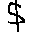

In [13]:
from IPython.display import Image as displayImage
def predict_single_image(model, image_path, device):
    """
    Loads a single image, processes it, and returns the model's prediction, 
    confidence, and the top 5 predictions.
    """
    
    # 1. Load and Transform Image
    try:
        # Load as grayscale (L) and apply the same transformations as training
        image = Image.open(path).convert("L")
        input_tensor = transform(image)
        
        # Add a batch dimension: [C, H, W] -> [1, C, H, W]
        input_batch = input_tensor.unsqueeze(0) 
    except FileNotFoundError:
        print(f"Error: Image file not found at {os.path.join(start, image_path)}")
        return
    except Exception as e:
        print(f"Error loading or transforming image: {e}")
        return

    # 2. Move to Device and Set to Evaluation Mode
    input_batch = input_batch.to(device)
    model.eval()

    # 3. Generate Prediction
    with torch.no_grad():
        output = model(input_batch)

    # 4. Process Output
    # Convert logits to probabilities using Softmax
    probabilities = nn.functional.softmax(output, dim=1)
    
    # Get the top prediction and its confidence
    confidence, predicted_class = torch.max(probabilities, 1)
    
    # Get the top 5 predictions
    top5_confidences, top5_indices = torch.topk(probabilities, 5)

    # Convert tensors to standard Python values/lists
    predicted_class_id = predicted_class.item()
    confidence_value = confidence.item()

    print(f'\n--- SINGLE IMAGE PREDICTION RESULTS ---')
    print(f'Input Image: {image_path}')
    print(f'Predicted Class ID: {predicted_class_id} / {classes[predicted_class_id]}')
    print(f'Confidence: {confidence_value:.4f}')
    print(f'\nTop 5 Predictions:')
    for i in range(5):
        class_id = top5_indices[0][i].item()
        conf = top5_confidences[0][i].item()
        print(f'  {i+1}. Class ID {class_id} / {classes[class_id]}: Confidence {conf:.4f}')

# Run single image prediction
idx = test_csv.iloc[5600]
path = start+"/"+idx["path"]

# predict_single_image(bs,path,device)
predict_single_image(bs, path, device)
print("Actual:",idx["latex"])
print("Image:")
displayImage(path)
